In [44]:
# Step 1: Install necessary libraries
!pip install opencv-python-headless
!pip install pywavelets  # For Haar transform

# Step 2: Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from scipy.fft import fft2, ifft2
from pywt import wavedec2, waverec2  # PyWavelets (wavelet transforms)
from scipy.linalg import hadamard
from sklearn.decomposition import PCA
import os  # For checking file existence

# Helper Function for Normalizing Transform Results
def normalize_image(image):
    image = np.abs(image)  # Absolute value for frequency domain transforms
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255  # Normalize to [0, 255]
    return image.astype(np.uint8)

In [47]:
# Step 3: Load the CT image from disk if it exists
def load_ct_image():
    filename = 'SKULL_CT.jpg' #source-uman_Skull_2 Free DICOM file by Medimodel team (https://medimodel.com/sample-dicom-files/human_skull_2_dicom_file/)

    if os.path.exists(filename):
        print(f"File '{filename}' found, loading the image.")
        # Read the image in grayscale using OpenCV
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        raise FileNotFoundError(f"File '{filename}' not found. Please ensure it is uploaded or in the environment.")

    # Resize image to manageable dimensions
    image = cv2.resize(image, (256, 256))  # Resize to 256x256 for consistency
    return image

# Step 4: Display two images side by side (Original and Transformed)
def display_images_side_by_side(original, transformed, title1="Original", title2="Transformed"):
    plt.figure(figsize=(10, 5))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title(title1)
    plt.axis('off')

    # Display transformed image
    plt.subplot(1, 2, 2)
    plt.imshow(np.log(np.abs(transformed) + 1), cmap='gray')  # Log scale for better visualization
    plt.title(title2)
    plt.axis('off')

    # Show both images
    plt.show()

In [48]:
# Step 5: Perform DCT (Discrete Cosine Transform)
def perform_dct(image):
    # Apply 2D DCT
    dct_transformed = dct(dct(image.T, norm='ortho').T, norm='ortho')
    return dct_transformed

# Step 6: Perform DFT (Discrete Fourier Transform)
def perform_dft(image):
    # Apply 2D DFT
    dft_transformed = np.fft.fftshift(fft2(image))
    return dft_transformed

# Step 7: Perform Haar Wavelet Transform
def perform_haar(image):
    # Apply 2D Haar Wavelet Transform (1-level decomposition)
    coeffs = wavedec2(image, 'haar', level=1)
    return coeffs

# Step 8: Perform Hadamard Transform
def pad_to_power_of_2(image):
    # Pad image to the nearest power of 2
    rows, cols = image.shape
    new_size = 2 ** int(np.ceil(np.log2(max(rows, cols))))

    # Create a new square image with padding (if necessary)
    padded_image = np.zeros((new_size, new_size))
    padded_image[:rows, :cols] = image  # Place the original image in the top-left corner
    return padded_image

def perform_hadamard(image):
    # Pad the image to the nearest power of 2
    padded_image = pad_to_power_of_2(image)

    # Generate Hadamard matrix for the size of the padded image
    N = hadamard(padded_image.shape[0])

    # Apply Hadamard transform
    hadamard_transformed = np.dot(np.dot(N, padded_image), N)

    # Crop back to the original image size after transform
    return hadamard_transformed[:image.shape[0], :image.shape[1]]

# Step 9: Perform KL Transform (PCA Approximation)
def perform_kl_transform(images):
    # Flatten images for PCA
    flat_images = [img.flatten() for img in images]

    # Apply PCA (KLT)
    pca = PCA(n_components=0.95)  # Retain 95% variance
    pca_transformed = pca.fit_transform(flat_images)
    return pca_transformed

In [49]:
# Step 10: Load the CT image
image = load_ct_image()

File 'SKULL_CT.jpg' found, loading the image.


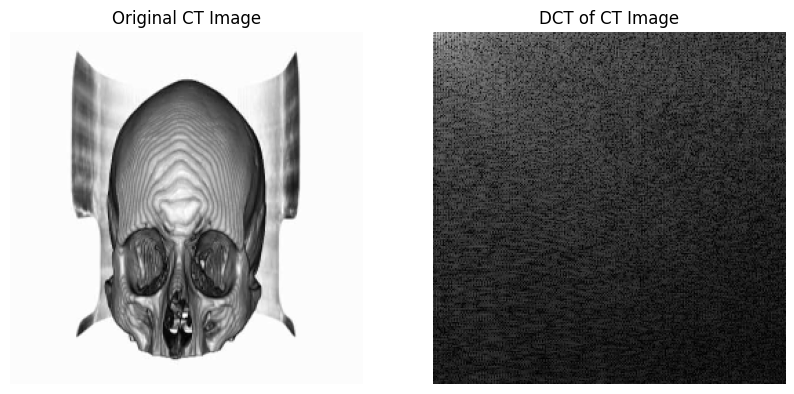

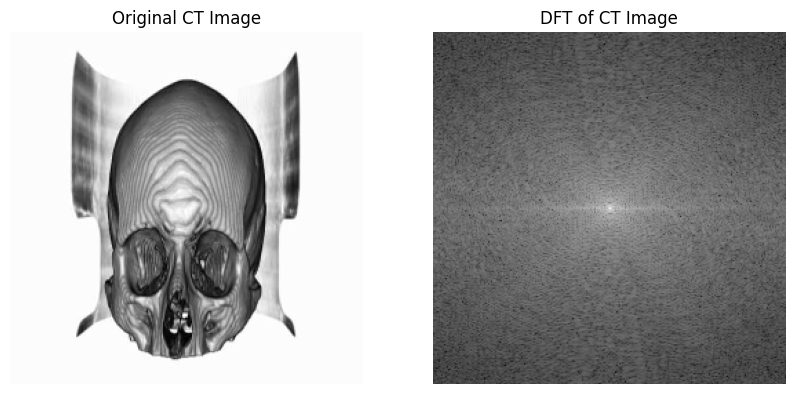

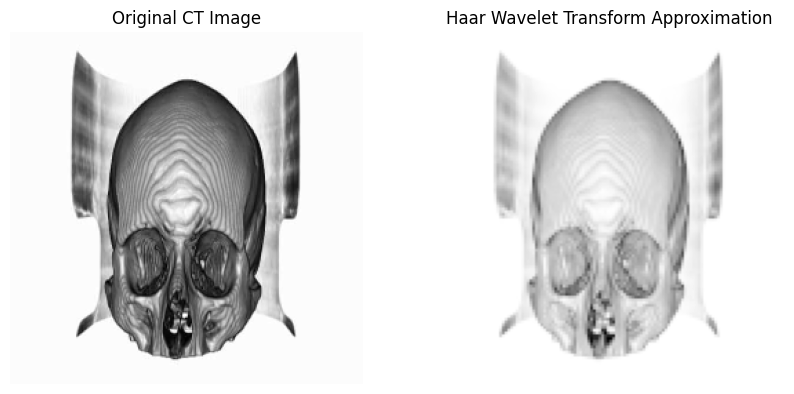

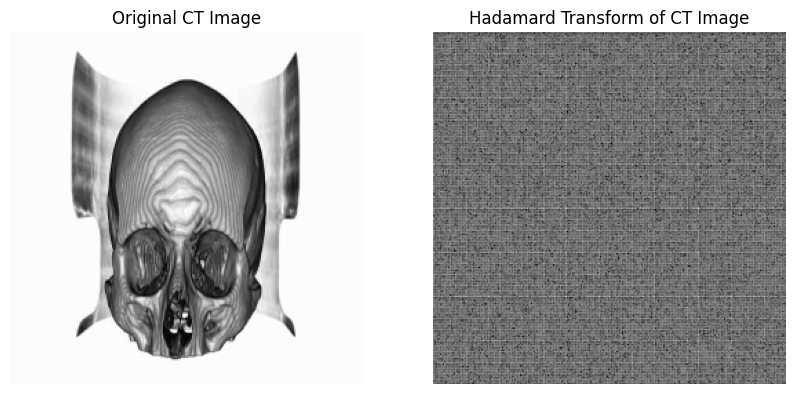

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:591: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


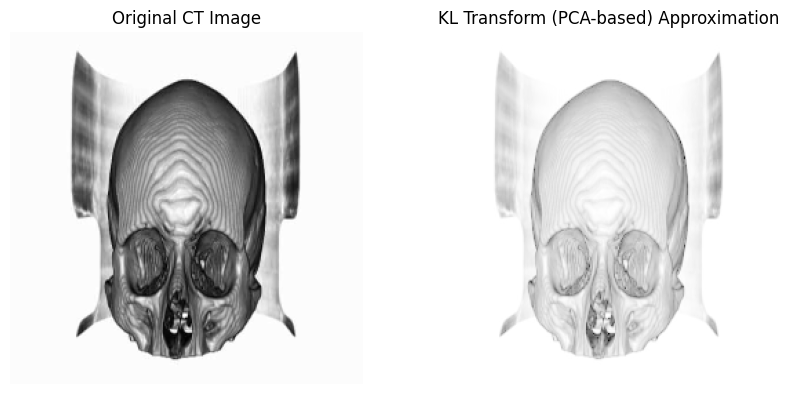

In [50]:
# Step 11: Apply and display DCT
dct_result = perform_dct(image)
display_images_side_by_side(image, dct_result, "Original CT Image", "DCT of CT Image")

# Step 12: Apply and display DFT
dft_result = perform_dft(image)
display_images_side_by_side(image, dft_result, "Original CT Image", "DFT of CT Image")

# Step 13: Apply and display Haar Wavelet Transform (Approximation coefficients only)
haar_result = perform_haar(image)
display_images_side_by_side(image, haar_result[0], "Original CT Image", "Haar Wavelet Transform Approximation")

# Step 14: Apply and display Hadamard Transform
hadamard_result = perform_hadamard(image)
display_images_side_by_side(image, hadamard_result, "Original CT Image", "Hadamard Transform of CT Image")

# Step 15: Perform KL Transform (PCA-based) for a single image
def perform_kl_transform_single(image):
    # Flatten the image
    flat_image = image.flatten().reshape(1, -1)

    # Apply PCA (KLT)
    pca = PCA(n_components=0.95)  # Retain 95% variance
    pca_transformed = pca.fit_transform(flat_image)

    # Reconstruct the image after PCA
    reconstructed_image = pca.inverse_transform(pca_transformed).reshape(image.shape)

    return reconstructed_image

# Step 15: Apply and display KL Transform (PCA-based)
kl_result = perform_kl_transform_single(image)
display_images_side_by_side(image, kl_result, "Original CT Image", "KL Transform (PCA-based) Approximation")


<ipython-input-47-f0399aa50b26>:28: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(transformed) + 1), cmap='gray')  # Log scale for better visualization


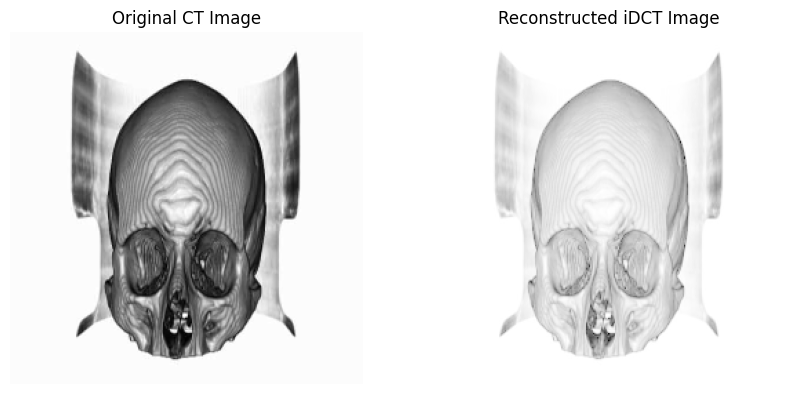

In [51]:
# Perform Inverse DCT
def perform_idct(dct_image):
    # Apply 2D iDCT
    idct_transformed = idct(idct(dct_image.T, norm='ortho').T, norm='ortho')
    return idct_transformed

# Apply iDCT and display
idct_result = perform_idct(dct_result)
display_images_side_by_side(image, normalize_image(idct_result), "Original CT Image", "Reconstructed iDCT Image")


<ipython-input-47-f0399aa50b26>:28: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(transformed) + 1), cmap='gray')  # Log scale for better visualization


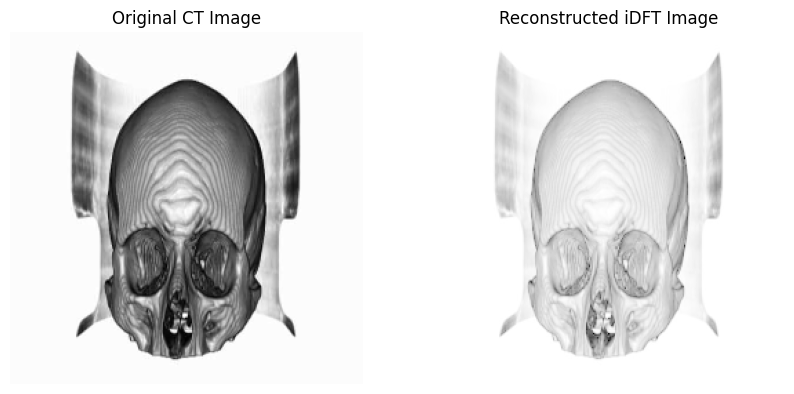

In [52]:
# Perform Inverse DFT
def perform_idft(dft_image):
    # Shift back and apply iDFT
    idft_transformed = ifft2(np.fft.ifftshift(dft_image)).real  # Take the real part
    return idft_transformed

# Apply iDFT and display
idft_result = perform_idft(dft_result)
display_images_side_by_side(image, normalize_image(idft_result), "Original CT Image", "Reconstructed iDFT Image")


<ipython-input-47-f0399aa50b26>:28: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(transformed) + 1), cmap='gray')  # Log scale for better visualization


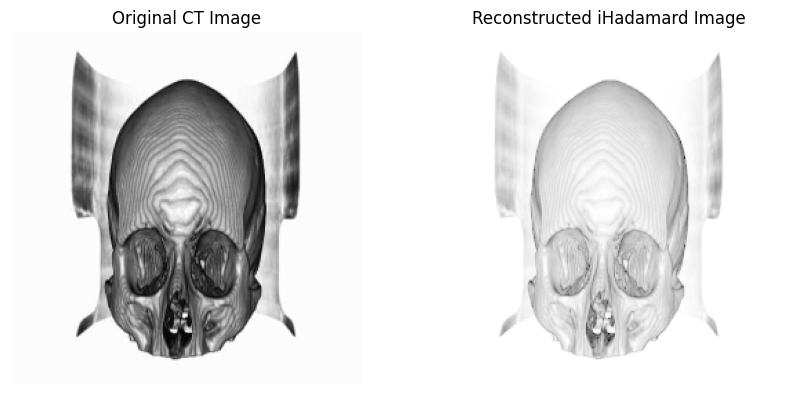

In [53]:
# Perform Inverse Hadamard Transform
def perform_ihadamard(hadamard_image):
    # Apply Hadamard transform again (same process as forward Hadamard)
    padded_image = pad_to_power_of_2(hadamard_image)
    N = hadamard(padded_image.shape[0])
    ihadamard_transformed = np.dot(np.dot(N, padded_image), N)
    return ihadamard_transformed[:image.shape[0], :image.shape[1]]  # Crop back to original size

# Apply iHadamard and display
ihadamard_result = perform_ihadamard(hadamard_result)
display_images_side_by_side(image, normalize_image(ihadamard_result), "Original CT Image", "Reconstructed iHadamard Image")


KL Transform (PCA-based) and Haar Wavelet Transform behave differently from DCT, DFT, and Hadamard, because they are directly working in the spatial domain. Let’s break down why they output images that can be directly displayed without requiring an inverse transform, while others like DCT, DFT, and Hadamard do require inversion to recover the image in the spatial domain.

1. KL Transform (PCA-based):
The Karhunen-Loève Transform (KLT), often implemented as PCA, works by reducing the dimensionality of the data while retaining the most important information (variance). It compresses the image but does not convert it into a frequency domain.

How it works: PCA transforms the image into a set of principal components, which are essentially directions of maximum variance. The result after PCA is still in the spatial domain but represents the image in a compressed form.
Reconstruction: The image can be directly reconstructed by taking the principal components back to the original image space.
So, when you apply PCA (KL Transform), you can display the resulting image directly because the transformed image still represents spatial pixel values, though some information (variance) might be discarded for compression.

2. Haar Wavelet Transform:
The Haar Wavelet Transform is a type of multi-resolution analysis that works by splitting the image into different frequency components (approximation and detail coefficients) but in the spatial domain.

How it works: The Haar transform splits the image into low-frequency (approximation) and high-frequency (detail) components, but these components are still spatial (pixel-based). For example, the approximation coefficients represent the low-resolution version of the image.
Display: The approximation coefficients (low-frequency) can be displayed directly because they still represent spatial information.
When we display just the approximation coefficients, it’s like showing a blurred, low-resolution version of the image.

3. Why DCT, DFT, and Hadamard Need Inverse Transforms:
These transforms convert the image from the spatial domain to the frequency domain:

DCT (Discrete Cosine Transform): Converts the image into cosine frequency components.
DFT (Discrete Fourier Transform): Converts the image into sine and cosine frequency components.
Hadamard Transform: Uses a Hadamard matrix to transform the image into a form similar to frequency space.
These transforms give you information about how much of each frequency is present in the image, but they do not represent pixel intensities directly. To recover an image that can be displayed as pixel intensities, you must perform the inverse transform.

Summary:
KL Transform (PCA-based): Directly outputs a reconstructed (compressed) image that is still in the spatial domain, so no inverse transform is needed.
Haar Wavelet Transform: Outputs approximation and detail coefficients that still represent spatial features of the image, allowing direct display.
DCT, DFT, Hadamard: Transform the image into frequency components and require inverse transforms to convert the image back to the spatial domain, where pixel intensities can be displayed.